<a href="https://www.kaggle.com/mykeysid10/sms-spam-ham-classification-using-nlp?scriptVersionId=88551398" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# SMS Spam Ham Classification using Natural Language Processing 

![](https://www.teltarif.de/img/arch/2021/kw16/spm-sms-gefaehrlich-1og.jpg)

# Importing Libraries

In [1]:
# General

import numpy as np
import pandas as pd
import re
import os
import pickle

# EDA

import matplotlib.pyplot as plt
import plotly.express as px
from wordcloud import WordCloud
from collections import Counter

# NLP 

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

# ML

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score

# Reading Data

In [2]:
df = pd.read_csv("../input/sms-spam-collection-dataset/spam.csv", encoding = 'latin-1')
df.drop(df.columns[[2,3,4]], axis = 1, inplace = True)
df.columns = ['target','message']
df.head()

,target,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Adding Features

In [3]:
df['no_of_chars'] = df['message'].apply(len)
df['no_of_words'] = df['message'].apply(lambda x: len(nltk.word_tokenize(x)))
df['no_of_sents'] = df['message'].apply(lambda x: len(nltk.sent_tokenize(x)))
df['Temp'] = df['target'].map({'ham': 0, 'spam': 1})

df.head()

,target,message,no_of_chars,no_of_words,no_of_sents,Temp
0,ham,"Go until jurong point, crazy.. Available only ...",111,23,2,0
1,ham,Ok lar... Joking wif u oni...,29,8,2,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,1
3,ham,U dun say so early hor... U c already then say...,49,13,1,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1,0


# Exploratory Data Analysis

#### 1. Count Plot

In [4]:
temp = pd.DataFrame()
temp['Target'] = ['Ham','Spam']
temp['Count'] = [len(df[df['target'] == 'ham']), len(df[df['target'] == 'spam'])]
temp = temp.sort_values(by = ['Count'], ascending = False)
fig = px.bar(temp, x = 'Target', y = 'Count', 
             color = "Target", text_auto='', width = 600, 
             color_discrete_sequence = ["#AB63FA", "orange"],
             template = 'plotly_dark',
            title = "Count Plot")

fig.update_xaxes(showgrid = False)
fig.update_yaxes(showgrid = False)
fig.update_traces(textfont_size=12, textangle = 0, textposition = "outside", cliponaxis = False)
fig.show()

#### 2. Pie Chart

In [5]:
fig = px.pie(temp, values = 'Count', names = 'Target', width = 600, 
             color = 'Target', color_discrete_map = {'Ham': 'rgb(166, 216, 84)', 'Spam': 'rgb(228, 26, 28)'},
             template = 'plotly_dark', title = "Pie Chart")
fig.show()

#### 3. Histograms

In [6]:
fig = px.histogram(df, x = 'no_of_chars', color = 'target', 
                   template = 'plotly_dark', 
                   title = "Histogram for HAM vs SPAM based on Number of Characters per Message")

fig.update_xaxes(showgrid = False)
fig.update_yaxes(showgrid = False)
fig.update_layout(barmode = 'overlay')
fig.show()

In [7]:
fig = px.histogram(df, x = 'no_of_words', color = 'target', 
                   template = 'plotly_dark', 
                   title = "Histogram for HAM vs SPAM based on Number of Words per Message")

fig.update_xaxes(showgrid = False)
fig.update_yaxes(showgrid = False)
fig.update_layout(barmode = 'overlay')
fig.show()

In [8]:
fig = px.histogram(df, x = 'no_of_sents', color = 'target', template = 'plotly_dark', title = "Histogram for HAM vs SPAM based on Number of Sentences per Message")
fig.update_xaxes(showgrid = False)
fig.update_yaxes(showgrid = False)
fig.update_layout(barmode = 'overlay')
fig.show()

#### 4. Pair Plot

In [9]:
fig = px.scatter_matrix(df, dimensions=["no_of_chars", "no_of_words", "no_of_sents"], 
                        color = "target", template = 'plotly_dark', 
                        color_discrete_map = {'ham': '#19D3F3', 'spam': '#FF9900'},
                        title = "Pair Plot")
fig.show() 

#### 5. Correlation Matrix

In [10]:
fig = px.imshow(df.corr(), text_auto = True, color_continuous_scale = 'blues', template = 'plotly_dark', title = "Correlation Matrix")
fig.show()

# Data Preprocessing

#### Word Count Function

In [11]:
def word_count_plot(data, title):
    word_counter = Counter([word for sentence in data for word in sentence.split()])
    most_count = word_counter.most_common(25)
    most_count = pd.DataFrame(most_count, columns = ['Word', 'Count']).sort_values(by = "Count")
    most_count = most_count.sort_values(by = 'Count', ascending = False)
    
    fig = px.bar(most_count, x = 'Word', y = 'Count', color = "Count", text_auto = '', template = 'plotly_dark', title = title)
    fig.update_xaxes(showgrid = False)
    fig.update_yaxes(showgrid = False, showticklabels = False)
    fig.update_traces(textfont_size = 12, textangle = 0, textposition = "outside", cliponaxis = False)
    fig.show()

#### Word Count Plot before Stemming

In [12]:
word_count_plot(df["message"], "Word Count Plot Before Stemming")

#### Creating Corpus

In [13]:
corpus = []
ps = PorterStemmer()

for i in range(len(df)):
    msg = re.sub('[^a-zA-Z]', ' ', df['message'][i]) 
    msg = msg.lower()
    msg = msg.split()
    msg = [ps.stem(word) for word in msg if not word in stopwords.words('english')] # Stemming & Stopwords Removal
    msg = ' '.join(msg)
    corpus.append(msg)

for i in range(0, 5):
    print("Sentence {}: {}".format(i+1,corpus[i]))

Sentence 1: go jurong point crazi avail bugi n great world la e buffet cine got amor wat
Sentence 2: ok lar joke wif u oni
Sentence 3: free entri wkli comp win fa cup final tkt st may text fa receiv entri question std txt rate c appli
Sentence 4: u dun say earli hor u c alreadi say
Sentence 5: nah think goe usf live around though


In [14]:
df['corpus'] = corpus
df.head()

,target,message,no_of_chars,no_of_words,no_of_sents,Temp,corpus
0,ham,"Go until jurong point, crazy.. Available only ...",111,23,2,0,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,29,8,2,0,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,1,free entri wkli comp win fa cup final tkt st m...
3,ham,U dun say so early hor... U c already then say...,49,13,1,0,u dun say earli hor u c alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1,0,nah think goe usf live around though


#### Word Count Plot after Stemming

In [15]:
word_count_plot(corpus, "Word Count Plot After Stemming")

#### Word Cloud Analysis on Corpus for Spam Messages

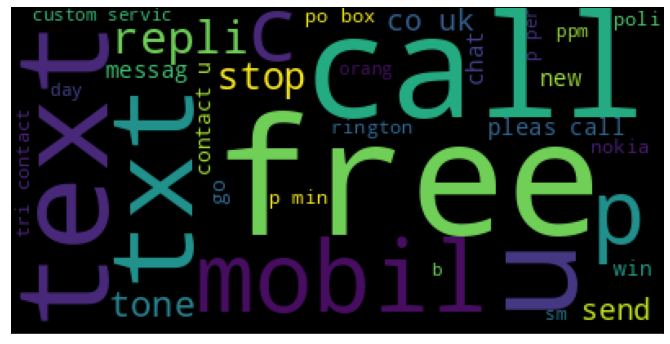

In [16]:
plt.figure(figsize = (24, 6))
wc = WordCloud(min_font_size = 10, background_color = 'black')
spam_wc = wc.generate(df[df['target'] == 'spam']['corpus'].str.cat(sep = " "))
plt.xticks([])
plt.yticks([])
plt.imshow(spam_wc);

#### Word Cloud Analysis on Corpus for Ham Messages

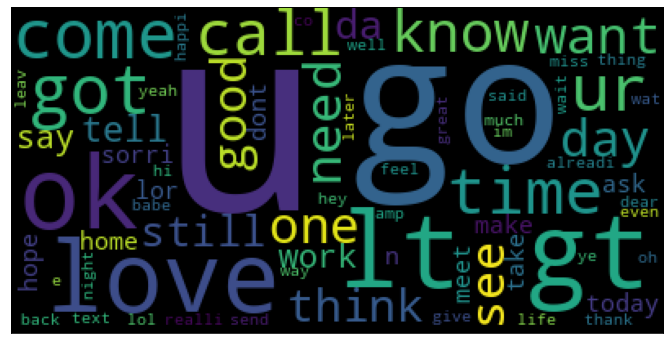

In [17]:
plt.figure(figsize = (24, 6))
wc = WordCloud(min_font_size = 10, background_color = 'black')
ham_wc = wc.generate(df[df['target'] == 'ham']['corpus'].str.cat(sep = " "))
plt.xticks([])
plt.yticks([])
plt.imshow(ham_wc);

#### Count Plot for Spam Words

In [18]:
spam_corpus = []

for msg in df[df['target'] == 'spam']['corpus'].tolist():
    for word in msg.split():
        spam_corpus.append(word)

temp = pd.DataFrame(Counter(spam_corpus).most_common(20), columns = ['Word', 'Count'])

fig = px.bar(temp, x = 'Word', y = 'Count', color = "Count", text_auto = '', template = 'plotly_dark', title = 'Count Plot for Spam Words')
fig.update_xaxes(showgrid = False)
fig.update_yaxes(showgrid = False, showticklabels = False)
fig.update_traces(textfont_size = 12, textangle = 0, textposition = "outside", cliponaxis = False)
fig.show()

# Data Manipulation

#### TF-IDF Vectorizer

In [19]:
tfidf = TfidfVectorizer(max_features = 3000)
X = tfidf.fit_transform(df['corpus']).toarray()
Y = df['Temp'].values

# Data Modeling

#### Train Test Split

In [20]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(4457, 3000) (1115, 3000) (4457,) (1115,)


#### Evaluation Metrics Function

In [21]:
def evaluation_parametrics(name, y_train, yp_train, y_test, yp_test):
    
    print("\n-----------------------------{}-----------------------------\n".format(name))
    
    cm_train = confusion_matrix(y_train, yp_train)
    t1 = ConfusionMatrixDisplay(cm_train)
    s1 = round((cm_train[0,0]/(cm_train[0,0] + cm_train[0,1])),4)
    
    print("Classification Report for Train Data\n")
    print(classification_report(y_train, yp_train)) 
    print("--------------------------------------------------------------------------")
    print("Specificity on Train Data: ", s1)
    print("Accuracy on Train Data: ", round(accuracy_score(y_train, yp_train),4))
    print("F1 Score on Train Data: ", round(f1_score(y_train, yp_train),4))
    print("--------------------------------------------------------------------------")
          
    cm_test = confusion_matrix(y_test, yp_test)
    t2 = ConfusionMatrixDisplay(cm_test)
    s2 = round((cm_test[0,0]/(cm_test[0,0] + cm_test[0,1])),4)
    
    print("\nClassification Report for Test Data\n")
    print(classification_report(y_test, yp_test))   
    print("--------------------------------------------------------------------------")
    print("Specificity on Test Data: ", s2)
    print("Accuracy on Test Data: ", round(accuracy_score(y_test, yp_test), 4))
    print("F1 Score Test Data: ", round(f1_score(y_test, yp_test), 4))
    print("--------------------------------------------------------------------------")
    
    t1.plot()
    t2.plot()

#### Naive Bayes Classifier


-----------------------------Naive Bayes Classifier-----------------------------

Classification Report for Train Data

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3860
           1       0.99      0.88      0.94       597

    accuracy                           0.98      4457
   macro avg       0.99      0.94      0.96      4457
weighted avg       0.98      0.98      0.98      4457

--------------------------------------------------------------------------
Specificity on Train Data:  0.9992
Accuracy on Train Data:  0.9836
F1 Score on Train Data:  0.9352
--------------------------------------------------------------------------

Classification Report for Test Data

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       965
           1       1.00      0.81      0.90       150

    accuracy                           0.97      1115
   macro avg       0.99      0.91      0.94    

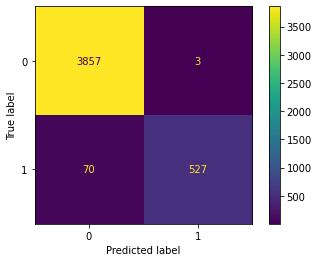

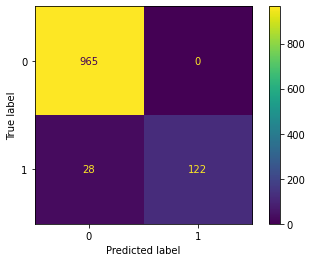

In [22]:
nb = MultinomialNB()
nb.fit(x_train, y_train)

yp_train = nb.predict(x_train)
yp_test = nb.predict(x_test)

evaluation_parametrics("Naive Bayes Classifier", y_train, yp_train, y_test, yp_test)

# Saving Model & Vectorizer

In [23]:
pickle.dump(nb, open('nb_model.pkl', 'wb'))
pickle.dump(tfidf, open('vectorizer.pkl', 'wb'))

# Do upvote if you find this Notebook useful... 😃 

<br>

#### 1. [Data Source](https://www.kaggle.com/uciml/sms-spam-collection-dataset)
#### 2. [Github](https://github.com/mykeysid10/Spam-Ham-Classification)